<a id="Title"></a>
# <span style="color:teal;font-weight:bold;">Spaceship Titanic 🩹 Data imputation</span>

This notebook is the third part of my <span style="font-weight:bold;color:green">Spaceship Titanic series</span>:

1. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar">Spaceship Titanic 🏁 Getting familiar</a>.
2. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>
3. <span style="font-weight:bold">Spaceship Titanic 🩹 Data imputation.</span> [This notebook]
4. Spaceship Titanic 🖥️ Model optimization. (Coming soon)
5. Spaceship Titanic 🔭 Integrated analysis. (Coming soon)

In the <span style="color:orangered;font-weight:bold;">first episode</span>, I studied the Leaderboard (LB) and tried simple Machine Learning models with the original dataset, getting a <span style="color:orangered;font-weight:bold;">submission score of 0.79635</span>. 

From that experience, I learned that **$\approx$75% of the submissions in the LB are below a 0.80 score, while only $\approx$5% are above 0.81**.

In the <span style="color:orange;font-weight:bold;">second episode</span>, I performed feature engineering on the original dataset (without any data correction), getting a <span style="color:orange;font-weight:bold;">submission score of 0.80336</span>.

<div style="color:white;
    display:fill;
    border-radius:15px;
    margin-left: 100px;
    margin-right: 100px;
    background-color:lightblue;
    font-size:105%;
    font-family:Verdana;
    letter-spacing:0.5px">

<p style="padding: 20px;color:black;text-align:center;">
In this <span style="color:green;font-weight:bold;">notebook</span>, I use my previously engineered features and focus on <span style="font-weight:bold;">data imputation</span> employing my own Machine Learning methods, getting a <span style="color:green;font-weight:bold;">submission score of X</span>.

</p>
</div>



In the future notebooks, I'll optimize the Machine Learning model and finally make an integrated analysis based on my results and a deep study of other kagglers' contributions.

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

[**Load data and preprocess**](#Load_data_and_preprocess)

  - [Load original data](#Load_original_data)

  - [Basic feature engineering](#Basic_feature_engineering)

[**Manual data correction**](#Manual_data_correction)

  - [Feature Cryosleep](#Manual_data_correction_Feature_Cryosleep)

  - [Feature HomePlanet](#Manual_data_correction_Feature_HomePlanet)

  - [Feature Age](#Manual_data_correction_Feature_Age)

[**ML data imputation**](#ML_data_imputation)

  - [Method description](#Method_description)

  - [Data selection](#Data_selection)

  - [Model tests](#Model_tests)

  - [Data imputation](#Data_imputation)

    - [Feature_X](#Data_imputation_Feature_X)
  
[**Feature engineering**](#Feature_engineering)

  - [Engineer features](#Engineer_features)
   
  - [Correlations](#Correlations)
   
  - [Combined features](#Feature_engineering_combined)
   
[**Submission results**](#Submission_results)

  - [Try models](#Try_models)
    
  - [Analyze results](#Analyze_results)
  
[**Conclusions**](#Conclusions)

<a id="Load_data_and_preprocess"></a>
# <span style="color:teal;font-weight:bold;">Load data and preprocess</span>

In this section, I load the original data and make basic feature engineering, in which I only extract information from single variables or change names. Other feature engineering processes that relate two or more features will come later.

In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2025-02-22 17:17:15.411762


<a id="Load_original_data"></a>
## <span style="color:teal;font-weight:bold;">Load original data</span>

In the following lines, I load the original datasets and get this information:

- Example for 10 random rows in training dataset.

- Number of rows in both datasets.

- Features' names and data types.

- Number of missing values in both datasets, per feature and per row.

In [2]:
import pandas as pd
import numpy as np
from termcolor import colored

# Load original datasets:
train_df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv') # Training dataset
test_df = pd.read_csv('kaggle/input/spaceship-titanic/test.csv') # Testing dataset
# Keep the passengerID features separately:
train_ID = train_df['PassengerId']
test_ID = test_df['PassengerId']
# Display a 10 random examples:
np.random.seed(1) # Ensure reproducitibility
samples = np.random.choice(range(len(train_df)), 10, replace=False)
display(train_df.iloc[samples]) # Examples
# Print global information:
print('\nNumber of rows in train/test datasets:\n')
print(len(train_df),'/',len(test_df))
print('\nFeatures: names and data types:\n')
print(train_df.dtypes)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
1454,1539_01,Europa,NaN,A/17/S,55 Cancri e,32.0,False,54.0,3782.0,0.0,21.0,5.0,Alyadum Barmant,True
218,0232_01,Earth,True,G/36/S,PSO J318.5-22,27.0,False,0.0,NaN,0.0,0.0,0.0,Nica Bakerrison,False
7866,8392_01,Earth,False,F/1610/S,PSO J318.5-22,24.0,False,86.0,669.0,1.0,0.0,0.0,Therly Brightez,False
7622,8141_01,Earth,True,G/1310/S,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,0.0,0.0,Stenny Belley,True
4108,4387_01,Mars,False,F/902/P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,18.0,0.0,Apix Wala,False
4363,4645_01,Europa,False,B/184/S,TRAPPIST-1e,48.0,False,0.0,9633.0,0.0,1.0,2.0,Aton Bacistion,True
343,0379_01,Earth,False,G/63/P,TRAPPIST-1e,31.0,False,198.0,0.0,591.0,0.0,164.0,Brita Moodson,True
5966,6324_01,Earth,False,E/420/S,NaN,31.0,False,19.0,509.0,0.0,0.0,177.0,Lesley Hinetthews,False
669,0699_01,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,True
6506,6865_01,Europa,False,D/208/S,TRAPPIST-1e,27.0,NaN,69.0,2878.0,0.0,4232.0,3798.0,Thabih Peducting,False



Number of rows in train/test datasets:

8693 / 4277

Features: names and data types:

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [3]:
def compute_missing_values(train_df,test_df):
    """
    Analyzes the missing values in each feature listed in the testing
    dataset, for both training and testing datasets.
    --- Inputs ---
    {train_df, test_df} [Dataframes]: Training and testing datasets.
    """
    print('\nMissing values in train/test datasets:\n')
    for col in test_df.columns:
        # Count missing values and obtain percentages:
        N_train = train_df[col].isna().sum() 
        N_test = test_df[col].isna().sum()
        p_train = N_train/len(train_df)*100 # [%]
        p_test = N_test/len(test_df)*100 # [%]
        # Print results:
        color_train = 'red' if N_train else 'green'
        color_test = 'red' if N_test else 'green'
        rmargin = 60-len(col)
        text_train = colored(f'{N_train} ({p_train:.1f}%)', color_train)
        text_test = colored(f'{N_test} ({p_test:.1f}%)', color_test)
        print(f'{col}:',f'{text_train} / {text_test}'.rjust(rmargin))
    # Count missing values in each row:
    N_nan_train = train_df.apply(lambda x: x.isna().sum(), axis=1)
    N_nan_test = test_df.apply(lambda x: x.isna().sum(), axis=1) 
    # Print number of rows with N missing values:
    print('')
    for n in set(N_nan_train).union(set(N_nan_test)):
        print(f'Number of rows with {n} missing values: {sum(N_nan_train==n)}/{sum(N_nan_test==n)}')

In [4]:
compute_missing_values(train_df,test_df)


Missing values in train/test datasets:

PassengerId:             0 (0.0%) / 0 (0.0%)
HomePlanet:           201 (2.3%) / 87 (2.0%)
CryoSleep:            217 (2.5%) / 93 (2.2%)
Cabin:               199 (2.3%) / 100 (2.3%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  203 (2.3%) / 93 (2.2%)
RoomService:          181 (2.1%) / 82 (1.9%)
FoodCourt:           183 (2.1%) / 106 (2.5%)
ShoppingMall:         208 (2.4%) / 98 (2.3%)
Spa:                 183 (2.1%) / 101 (2.4%)
VRDeck:               188 (2.2%) / 80 (1.9%)
Name:                 200 (2.3%) / 94 (2.2%)

Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1867/879
Number of rows with 2 missing values: 203/113
Number of rows with 3 missing values: 17/4


For more comments, please visit <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>

<a id="Basic_feature_engineering"></a>
## <span style="color:teal;font-weight:bold;">Basic feature engineering</span>

Except for the **PassengerID** feature, there are around 2% missing values in each feature of both training and testing datasets. In order to correct them, I'll make some fair assumptions and deductions using the original information. 

Then, **in this Basic feature engineering process I won't generate new features that involve two or more features, because that would multiply the missing values**. Instead, I will just extract information from the original features or make simple changes such as changing the feature name.

You can check my previous notebook <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a> for details about the engineering of single features. In the following, I just apply that code.

In [5]:
# First generate the corrected datasets:
train_df_SF = train_df.copy()
test_df_SF = test_df.copy()

# # # "PassengerId": new features "IDgroup" and "GroupMembers" # # #

train_df_SF['IDgroup'] = train_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
test_df_SF['IDgroup'] = test_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
# Identify ocurrences for every unique value in IDgroup:
ocurrences = pd.concat([train_df_SF['IDgroup'], test_df_SF['IDgroup']]).value_counts().to_dict()
for dataset in [train_df_SF,test_df_SF]:
    dataset['GroupMembers'] = dataset['IDgroup'].apply(lambda x: ocurrences[x])
# Drop unnecessary feature:
train_df_SF = train_df_SF.drop('PassengerId',axis=1)
test_df_SF = test_df_SF.drop('PassengerId',axis=1)

# # # "CryoSleep": make boolean/numeric # # #

for dataset in [train_df_SF,test_df_SF]:
    dataset['CryoSleep'] = dataset['CryoSleep'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

# # # "Cabin": new features "Cabin_Deck", "Cabin_num" and "Cabin_isPort" # # #

# Generate list of unique values:
cabin = list(train_df['Cabin'].loc[~train_df['Cabin'].isna()].values)+\
        list(test_df['Cabin'].loc[~test_df['Cabin'].isna()].values)
# Separate "Cabin" into three parts:
cabin_X = ['Cabin_Deck','Cabin_num','Cabin_Side']
for i,cabin in enumerate(cabin_X):
    train_df_SF[cabin] = train_df['Cabin'].apply(
        lambda x: np.nan if x!=x else (
            x.split('/')[i]))
    test_df_SF[cabin] = test_df['Cabin'].apply(
        lambda x: np.nan if x!=x else (
            x.split('/')[i]))
# Change 'Cabin_Side' to 'Cabin_isPort' and make it boolean/numeric:
train_df_SF['Cabin_isPort'] = train_df_SF['Cabin_Side'].apply(
    lambda x: np.nan if x!=x else (1 if x=='P' else 0))
test_df_SF['Cabin_isPort'] = test_df_SF['Cabin_Side'].apply(
    lambda x: np.nan if x!=x else (1 if x=='P' else 0))
# Drop unnecesary features:
for feature in ['Cabin','Cabin_Side']:
    train_df_SF = train_df_SF.drop(feature,axis=1)
    test_df_SF = test_df_SF.drop(feature,axis=1)

# # # "Destination" redefinition # # #

train_df_SF["Destination"] = train_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)
test_df_SF["Destination"] = test_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)

# # # Expense-features redefinition # # #

for dataset in [train_df_SF, test_df_SF]:
    dataset.rename(columns={
        'RoomService': 'ExpRS',
        'FoodCourt': 'ExpFC',
        'ShoppingMall': 'ExpSM',
        'Spa': 'ExpSpa',
        'VRDeck': 'ExpVR'
        }, inplace=True)

# # # "Name" feature: new features "Name_Last" and "Ocurrence_LastName" # # #

# Training dataset:
train_df_SF['Name_Last'] = train_df['Name'].apply(
    lambda x: np.nan if x!=x else (
        x.split(' ')[-1]))
# Testing dataset:
test_df_SF['Name_Last'] = test_df['Name'].apply(
    lambda x: np.nan if x!=x else (
        x.split(' ')[-1]))
# Identify ocurrences for every unique value in Name_Last:
ocurrences = pd.concat([train_df_SF['Name_Last'], test_df_SF['Name_Last']]).value_counts().to_dict()
for dataset in [train_df_SF,test_df_SF]:
    dataset['Ocurrence_LastName'] = dataset['Name_Last'].apply(
        lambda x: np.nan if x!=x else ocurrences[x])
# Drop unnecessary feature:
train_df_SF = train_df_SF.drop('Name',axis=1)
test_df_SF = test_df_SF.drop('Name',axis=1)

Below, I summarize all **features after the basic engineering process**:

| Feature | Definition |
| :---: | :--- |
| **IDgroup** | Indicates the group with which the passenger is travelling with. People in a group are often family members, but not always. |
| **GroupMembers** | Number of passengers sharing the same **IDgroup** (including self). |
| **Name_Last** | Last name of the passenger. |
| **Ocurrence_LastName** | Number of passengers sharing the same last name (including self). |
| **HomePlanet** | The planet the passenger departed from, typically their planet of permanent residence. |
| **CryoSleep** | Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins. |
| **Destination** | The planet the passenger will be debarking to. |
| **Age** | The age of the passenger. |
| **VIP** | Whether the passenger has paid for special VIP service during the voyage. |
| **Cabin_Deck** | Designation of the Deck in which the passenger's cabin is located |
| **Cabin_num** | Passenger's cabin number |
| **Cabin_isPort** | Side of the starship in which the passenger's cabin is located: a value 1 means Port, 0 means Starboard. |
| **ExpRS** | Amount the passenger has billed at the Room Service luxury amenity |
| **ExpFC** | Amount the passenger has billed at the Food Court luxury amenity |
| **ExpSM** | Amount the passenger has billed at the Shopping Mall luxury amenity |
| **ExpSpa** | Amount the passenger has billed at the Spa luxury amenity |
| **ExpVR** | Amount the passenger has billed at the VRDeck luxury amenity |

<a id="Manual_data_correction"></a>
# <span style="color:teal;font-weight:bold;">Manual data correction</span>

As the original features have changed their names and expanded into a new set, I compute again the missing values:

In [6]:
compute_missing_values(train_df_SF,test_df_SF)


Missing values in train/test datasets:

HomePlanet:           201 (2.3%) / 87 (2.0%)
CryoSleep:            217 (2.5%) / 93 (2.2%)
Destination:          182 (2.1%) / 92 (2.2%)
Age:                  179 (2.1%) / 91 (2.1%)
VIP:                  203 (2.3%) / 93 (2.2%)
ExpRS:                181 (2.1%) / 82 (1.9%)
ExpFC:               183 (2.1%) / 106 (2.5%)
ExpSM:                208 (2.4%) / 98 (2.3%)
ExpSpa:              183 (2.1%) / 101 (2.4%)
ExpVR:                188 (2.2%) / 80 (1.9%)
IDgroup:                 0 (0.0%) / 0 (0.0%)
GroupMembers:            0 (0.0%) / 0 (0.0%)
Cabin_Deck:          199 (2.3%) / 100 (2.3%)
Cabin_num:           199 (2.3%) / 100 (2.3%)
Cabin_isPort:        199 (2.3%) / 100 (2.3%)
Name_Last:            200 (2.3%) / 94 (2.2%)
Ocurrence_LastName:   200 (2.3%) / 94 (2.2%)

Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1551/723
Number of rows with 2 missing values: 289/152
Number of rows with 3 missing values: 202/101
Number

Again, about 2% of the values are missing in each feature, and now that the features have been divided into multiple subfeatures (such as **Cabin** into **Cabin_Deck**, **Cabin_num** and **Cabin_isPort**), now some rows have up to 5 or 6 missing values.

In the following, I analyze the single features and complete those missing values that can be deducted by reasonable assumptions.

In [7]:
# Define plotting functions:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_swarm(df,feat,axis,ref_feat='Transported',
               xlabels_off=False,seed=42):
    """
    Plots a swarm plot ordered by the transported rate from a 
    single feature within the dataset.
    --- Inputs ---
    {df} [Dataframe]: Dataset, must include the columns with 
    names {feat} and {ref_feat}.
    {feat} [String]: Name of the column (feature) to be analyzed.
    {ref_feat} [String]: Name of the column (feature) by which {feat} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    {xlabels_off} [Boolean]: If True, remove the x-labels.
    {seed} [Integer]: Seed for random scattering in swarm plots.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    data = df[feat] # Training dataset    
    data_counts = data.value_counts().sort_index()
    # For each variable, identify the transported rate and build the swarm plot:
    np.random.seed(seed) # Random seed for swarm plots
    for i, var in enumerate(data_counts.keys()):
        # Determine points' location:
        ref_rate = df.groupby([feat]).mean(numeric_only=True)[ref_feat].loc[var] # Reference rate
        pp_pos = int(len(df[(df[feat]==var)])*ref_rate) # Positive reference values
        pp_neg = int(len(df[(df[feat]==var)])*(1-ref_rate)) # Negative reference values
        var_pos = np.random.uniform(0, ref_rate,pp_pos) # Randomly assign locations for "positive" points
        var_neg = np.random.uniform(ref_rate,1,pp_neg) # Randomly assign locations for "negative" points              
        # Allocate all points in plot:
        color = np.array(sns.color_palette('tab20')[i])
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_neg)), var_neg,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     alpha=0.1, label=f'{var}({ref_feat}=0)')
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_pos)), var_pos,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     label=f'{var}({ref_feat}=1)')
        axis.plot([i-0.3,i+0.3],[ref_rate,ref_rate],ls='--',color='k',lw=1)
    # Ticks and limits:
    axis.set_xlim(-0.5, len(data_counts)-0.5)
    axis.set_ylim(-0.03, 1.1)
    if xlabels_off:
        axis.set_xticks([])
        axis.set_xticklabels([])
    else:
        axis.set_xticks(np.linspace(0,len(data_counts.keys())-1,len(data_counts.keys())))
        axis.set_xticklabels(data_counts.keys(), fontsize=10)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('')
    # Spines, legend and title:
    for s in ["top","right","left", 'bottom']:
        axis.spines[s].set_visible(False)
    axis.legend([0,1],title=ref_feat,loc=(0.8, 0.7), edgecolor='k')
    axis.set_title(f'Feature bars: {feat}; feature points: {ref_feat}')

import warnings # <sns.kdeplot> gives a warning I couldn't fix, I avoid displaying it...
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_KDE(df,feat,axis,ref_feat):
    """
    Plots a kernel density estimate (KDE) plot ordered by the 
    reference rate from a single feature within the dataset.
    --- Inputs ---
    {df} [Dataframe]: Training dataset, must include the columns with
    names {feat} and {ref_feat}.
    {feat} [String]: Name of the column (feature) to be analyzed.
    {ref_feat} [String]: Name of the column (feature) by which {feat} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    """    
    # Plot KDE:
    sns.kdeplot(x=feat, data=df, ax=axis, fill=True,cut=0,
                bw_method=0.15, lw=1.4, edgecolor='lightgray', hue=ref_feat,
                multiple="stack", palette='PuBu', alpha=0.8)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('Density')
    axis.set_title(f'{feat}: "{ref_feat}" rate')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)  

def single_feat_corr(df,feat_targ,feat_rel):
    """
    Plots the KDE distribution of values for a target feature within
    a single dataset, grouped by a relative feature.
    --- Inputs ---
    {df} [Dataframe]: Dataset that will be analyzed, must include the
    target {feat_targ} and relative {feat_rel} features.
    {feat_targ} [String]: Target feature.
    {feat_rel} [String]: Relative feature.
    """
    # First clean the dataset from the NaN values in the {feat_rel} feature:
    df_copy = df[[feat_targ,feat_rel]].copy()
    df_copy = df_copy.dropna()
    print("Number of known values:", df_copy[feat_targ].notna().sum())
    fig, ax = plt.subplots(figsize=(8,3)) # Start figure
    if df[feat_targ].dtype == 'object': # Non-numerical features:
        plot_swarm(df_copy,feat_targ,ax,ref_feat=feat_rel)    
    else: # Numerical features:
        plot_KDE(df_copy,feat_targ,ax,ref_feat=feat_rel)
    fig.tight_layout()

<a id="Manual_data_correction_Feature_Cryosleep"></a>
## <span style="color:teal;font-weight:bold;">Feature CryoSleep</span>

This is probably one of the easiest to start with, as passengers who went to cryosleeping shouldn't have registered any activity in the ship, therefore their expenses should be zero. Let's check that for known values: 

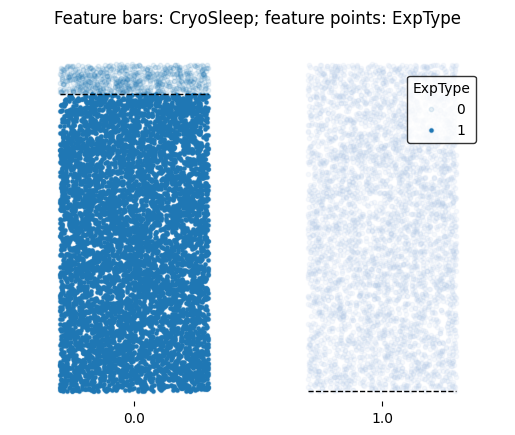

In [8]:
# Concatenate train and test datasets:
all_df = pd.concat([train_df_SF, test_df_SF])
# Compute the total expenses (missing values are replicated):
exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR']
all_df['ExpTotal'] = all_df[exp_features].sum(axis="columns")
# Create an auxiliar 'ExpType' feature, that checks whether a passenger...
#... spent nothing (0) or something (1), counting all expense types:
all_df['ExpType'] = 0 # Initiate
all_df.loc[all_df['ExpTotal']>0,'ExpType'] = 1 # Update neccesary values
# Study the CryoSleep vs ExpTotal distribution:
fig, ax = plt.subplots(1)
plot_swarm(all_df,'CryoSleep',ax,ref_feat='ExpType',
               xlabels_off=False,seed=42)

Looking at these plots, it becomes a certainty that if a passenger went into cyrosleep (**CryoSleep**=1), then they spent nothing during the trip (**ExpType**=0). As a consequence, **spending something during the trip** (**ExpType**=1) **implies that the passenger did not go into cryosleep**! Then, I will assign any missing **CryoSleep** values as 0 whenever **ExpType** is 1.

Conversely, if a passenger was awake during the trip (**CryoSleep**=0), then in most cases they spent something, but there are some other cases in which they spent nothing. Therefore, nothing can be certainly concluded for the **CryoSleep**=0, regarding the passenger's expenses.

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'
# Assign CryoSleep=0 for missing values, given the special circumstance than ExpType=1.
for dataset in [train_df_SF, test_df_SF]:
    if 'ExpTotal' not in dataset:
        # Create the 'ExpTotal' and 'ExpType' features:
        exp_features = ['ExpRS','ExpFC','ExpSM','ExpSpa','ExpVR']
        dataset['ExpTotal'] = dataset[exp_features].sum(axis="columns")
    if 'ExpType' not in dataset:
        dataset['ExpType'] = 0 # Initiate
        dataset.loc[dataset['ExpTotal']>0,'ExpType'] = 1 # Update neccesary values
    # Correct missing values:
    idx = (dataset['CryoSleep'].isna()) & (dataset['ExpType']==1) # Relevant indexes
    dataset['CryoSleep'].loc[idx] = 0

*Note*: in this process, the new feature **ExpTotal** sums all individual expenditures, including the NaN values! The NaN values are counted as 0. Although I did not analyze any of the expense features yet, I will tolerate this assumption for the **CryoSleep** analysis.

Let me summarize the progress so far for the **CryoSleep** feature: 
* Initial missing values: <span style="color:red">217 (2.5%) / 93 (2.2%)</span>.
* Current missing values: <span style="color:red">98 (1.1%) / 38 (0.9%)</span>.

(Remember you can call the function "compute_missing_values" at any step to see the number of missing values)

<a id="Manual_data_correction_Feature_HomePlanet"></a>
## <span style="color:teal;font-weight:bold;">Feature HomePlanet</span>

Passengers are organized in groups, identified by **IDgroup**. These groups have a common Home planet, as the next lines of code demonstrate:

In [10]:
for i in set(all_df['IDgroup']):
    # Make a set with all Home planets for the current group (exclude NaN):
    homes = set([x for x in all_df[all_df['IDgroup']==i]['HomePlanet'] if x==x])
    # If there is more than a single home planet in the group, print on screen:
    if len(homes)>1:
        print(i,all_df[all_df['IDgroup']==i]['HomePlanet'])

Consequently, any missing values in **HomePlanet** can be filled with the known destination of another passenger with the same **IDgroup**.

In [11]:
for dataset in [train_df_SF, test_df_SF]:
    idx = dataset.loc[pd.isna(dataset["HomePlanet"]), :].index # Relevant indexes
    for i in idx:
        homes = list(set([x for x in all_df[all_df['IDgroup']==dataset['IDgroup'][i]]['HomePlanet'] if x==x]))
        if len(homes)>0:
            dataset["HomePlanet"].loc[i] = homes[0]

As there are still missing values in **HomePlanet**, I turn my attention to the correlation with the **Cabin_Deck** feature, as they are highly correlated (see section Correlations II in <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-feature-engineering">Spaceship Titanic 💡 Feature engineering.</a>).

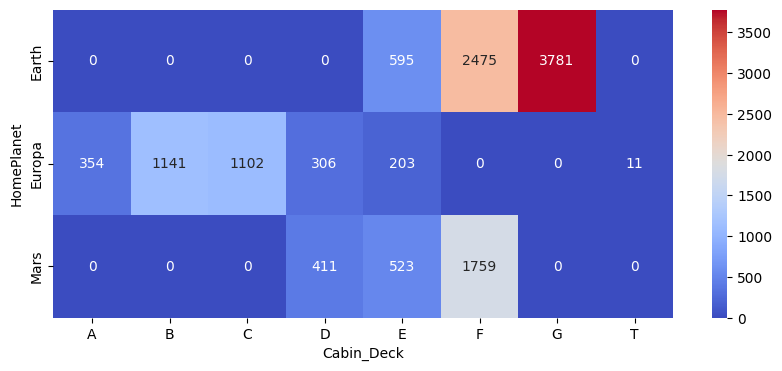

In [51]:
# Concatenate train and test datasets:
all_df = pd.concat([train_df_SF, test_df_SF])
CDHP_gb = all_df.groupby(['Cabin_Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
# Plot distribution:
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
fig.tight_layout()

From this distribution plot, I can conclude the following:
- Passengers in **Cabin_Deck** A,B,C,T are associated with the **HomePlanet** Europa.
- Passengers in **Cabin_Deck** G are associated with the **HomePlanet** Earth.
- Passengers in **Cabin_Deck** D,E,F cannot be clearly assigned to a **HomePlanet**.

In [13]:
# Assign HomePlanet values based on Cabin:
for dataset in [train_df_SF, test_df_SF]:
    # Cabins A,B,C,T, associated to Europa:
    cond_ABCT = ((dataset["Cabin_Deck"]=="A") |
                 (dataset["Cabin_Deck"]=="B") |
                 (dataset["Cabin_Deck"]=="C") |
                 (dataset["Cabin_Deck"]=="T")) # Define condition
    dataset["HomePlanet"].loc[cond_ABCT] = "Europa" # Apply changes
    # Cabins G, associated to Earth:
    cond_G = dataset["Cabin_Deck"]=="G" # Define condition
    dataset["HomePlanet"].loc[cond_G] = "Earth" # Apply changes

Let's summarize the progress so far for the **HomePlanet** feature: 
* Initial missing values: <span style="color:red">201 (2.3%) / 87 (2.0%)</span>.
* Current missing values: <span style="color:red">63 (0.7%) / 31 (0.7%)</span>.

I have one last resource! Before, I grouped the passengers according to their **IDgroup** and correlated their **HomePlanet**. I will do the same with the **Name_Last** feature, and show that all passengers sharing the same surname belong to the same **HomePlanet**:

In [15]:
all_df = pd.concat([train_df_SF, test_df_SF])
for surname in set(all_df["Name_Last"]):
    # Make a set with all Home planets for the current group (exclude NaN):
    homes = set([x for x in all_df[all_df['Name_Last']==surname]['HomePlanet'] if x==x])
    # If there is more than a single home planet in the group, print on screen:
    if len(homes)>1:
        print(surname,all_df[all_df['Name_Last']==surname]['HomePlanet'])

Consequently, any missing values in **HomePlanet** can be filled with the known destination of another passenger with the same **Name_Last**.

In [16]:
for dataset in [train_df_SF, test_df_SF]:
    idx = dataset.loc[pd.isna(dataset["HomePlanet"]), :].index # Relevant indexes
    for i in idx:
        homes = list(set([x for x in all_df[all_df['Name_Last']==dataset['Name_Last'][i]]['HomePlanet'] if x==x]))
        if len(homes)>0:
            dataset["HomePlanet"].loc[i] = homes[0]

Excellent news, now the **HomePlanet** feature presents only a few missing values! 
* Current missing values: <span style="color:red">5 (0.1%) / 5 (0.1%)</span>.

<a id="Manual_data_correction_Feature_Age"></a>
## <span style="color:teal;font-weight:bold;">Feature Age</span>

After exploring the correlation between **Age** and other features, I couldn't determine any certain rules related to features such as **VIP** or **CryoSleep**. However, I did observe a pattern related to the expenses:

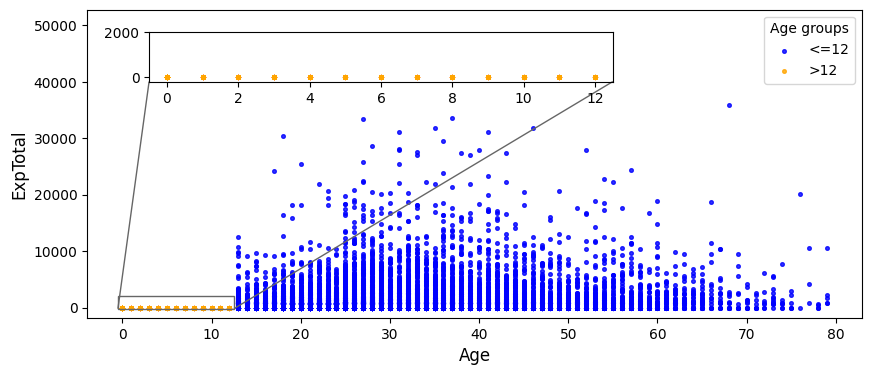

In [133]:
# Merge training and testing datasets:
all_df = pd.concat([train_df_SF, test_df_SF])
age_limit = 12 # Set age limit for zoomed-in plot

# Plot expenses vs age:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(all_df["Age"][~cond],all_df["ExpTotal"][~cond],s=7,alpha=0.8,color='blue',label='<=12')
ax.scatter(all_df["Age"][cond],all_df["ExpTotal"][cond],s=7,alpha=0.8,color='orange',label='>12')
ax.set_xlabel('Age',fontsize=12), ax.set_ylabel('ExpTotal',fontsize=12)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+15000)
ax.legend(title='Age groups')
# Zoomed-in image:
axins = zoomed_inset_axes(ax, 4, loc=6, bbox_to_anchor=[180,280,50,50])
cond = all_df["Age"] <= age_limit
axins.scatter(all_df["Age"][cond],all_df["ExpTotal"][cond],s=7,alpha=0.8,color='orange')
axins.set_xlim(-0.5, age_limit+0.5), axins.set_ylim(-200, 2000)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.4") # Lines for inset image
plt.show()

Passengers who are 12 or younger do not expend! The plot clearly shows that only passengers who are older than 12 spend money, meaning **ExpTotal**>0. 

In [ ]:
### WAIT, THIS IS A GOOD METHOD TO FILL IN EXPTOTAL VALUES: 
# ANY CHILD UNDER 12 DID NOT SPEND MONEY, THEN THEIR NAN VALUES CAN BE COMPUTED AS 0!
# THIS SECTION, CURRENTLY "AGE FEATURE", SHOULD BE "EXPENSES FEATURE",
# AND SHOULD BE MOVED TO THE BEGINNING, SO IT IS UPDATED BEFORE CRYOSLEEP ENGINEERING

In [17]:
### NOW, DO THE SAME WITH DESTINATION

In [24]:
all_df.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'ExpRS',
       'ExpFC', 'ExpSM', 'ExpSpa', 'ExpVR', 'Transported', 'IDgroup',
       'GroupMembers', 'Cabin_Deck', 'Cabin_num', 'Cabin_isPort', 'Name_Last',
       'Ocurrence_LastName', 'ExpTotal', 'ExpType'],
      dtype='object')

<Axes: xlabel='HomePlanet', ylabel='Destination'>

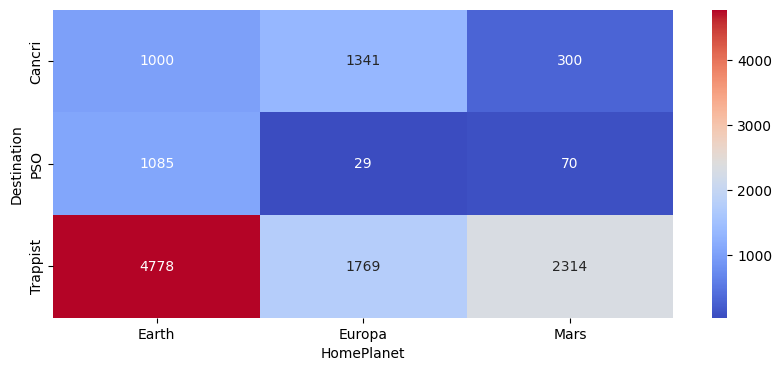

In [26]:
# Concatenate train and test datasets:
all_df = pd.concat([train_df_SF, test_df_SF])
CDHP_gb = all_df.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)
# Plot distribution:
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [27]:
#compute_missing_values(train_df_SF,test_df_SF)

<a id="ML_data_imputation"></a>
# <span style="color:teal;font-weight:bold;">ML data imputation</span>

Xxxx

<a id="Feature_engineering"></a>
# <span style="color:teal;font-weight:bold;">Feature engineering</span>

Xxxx

<a id="Submission_results"></a>
# <span style="color:teal;font-weight:bold;">Submission results</span>

Xxxx

<a id="Conclusions"></a>
# <span style="color:teal;font-weight:bold;">Conclusions</span>

Xxxx